# Keyword Spotting 

This notebook implements an attention RNN model as adapted from de Andrade et al. (2018) 

In [1]:
useColab=False
if useColab:
    %tensorflow_version 2.x
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechDownloader.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechGenerator.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/audioUtils.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechModels.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/requirements.txt
    !pip install -r requirements.txt

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import SpeechDownloader
import SpeechGenerator
import SpeechModels

In [ ]:
# Downloading Google Speech Commands Dataset (version 2)
gscInfo, nCategs = SpeechDownloader.PrepareGoogleSpeechCmd(version=2, task='35word')

  4%|▍         | 4.71k/110k [00:00<00:02, 47.1kKB/s]

110kKB [00:01, 98.0kKB/s]                         
  0%|          | 4.10k/2.37M [00:00<01:06, 35.4kKB/s]

2.37MKB [00:31, 75.0kKB/s]                           


Extracting sd_GSCmdV2/test.tar.gz into sd_GSCmdV2/test/
Extracting sd_GSCmdV2/train.tar.gz into sd_GSCmdV2/train/


  0%|          | 0/4890 [00:00<?, ?it/s]

Converting test set WAVs to numpy files


100%|██████████| 4890/4890 [00:08<00:00, 592.01it/s]


Converting training set WAVs to numpy files


100%|██████████| 105835/105835 [02:56<00:00, 598.21it/s] 


Done preparing Google Speech commands dataset version 2


In [ ]:
sr = 16000 #we know this one for google audios
iLen = 16000
trainGen = SpeechGenerator.SpeechGen(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
# handle the fact that number of samples in validation may not be multiple of batch_size with shuffle=True
valGen   = SpeechGenerator.SpeechGen(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)

# use batch_size = total number of files to read all test files at once
testGen  = SpeechGenerator.SpeechGen(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = SpeechGenerator.SpeechGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))
#valGen.__len__()

311

In [ ]:
audios, classes = valGen.__getitem__(1)
classes
#len(audios)

array([28,  6, 13, 20,  5, 12, 33, 21,  9, 15, 13,  1, 17, 27, 23, 26, 13,
       33, 16, 28, 15, 13,  6, 11, 12, 20, 10, 20, 15, 29, 12,  2])

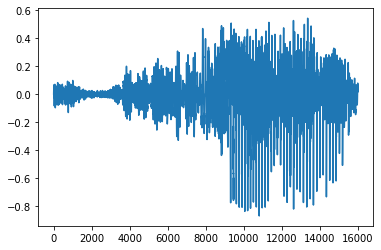

In [ ]:
plt.plot(audios[5])

In [ ]:
from tensorflow.keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

melspecModel = Sequential()

melspecModel.add(Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                         padding='same', sr=sr, n_mels=80,
                         fmin=40.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False,
                         name='mel_stft') )

melspecModel.add(Normalization2D(int_axis=0))

In [ ]:
melspec = melspecModel.predict( audios.reshape((-1,1,iLen)) )
melspec.shape

(32, 80, 125, 1)

In [ ]:
from tensorflow.keras.models import Model, load_model

from kapre.time_frequency import Melspectrogram, Spectrogram

Model

In [ ]:
model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, None)      0           input[0][0]                      
__________________________________________________________________________________________________
mel_stft (Melspectrogram)       (None, 80, None, 1)  1091664     reshape[0][0]                    
__________________________________________________________________________________________________
mel_stft_norm (Normalization2D) (None, 80, None, 1)  0           mel_stft[0][0]                   
_______________________________________________________________________________________

In [ ]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [ ]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint('model-attRNN.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results = model.fit(trainGen, validation_data=valGen, epochs=100, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, checkpointer, lrate])

model.save('model-attRNN.h5')

Changing learning rate to 0.001
Epoch 1/100

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.93629, saving model to model-attRNN.h5
2651/2651 - 175s - loss: 0.1092 - sparse_categorical_accuracy: 0.9690 - val_loss: 0.2467 - val_sparse_categorical_accuracy: 0.9363
Changing learning rate to 0.001
Epoch 2/100

Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.93629
2651/2651 - 208s - loss: 0.1070 - sparse_categorical_accuracy: 0.9701 - val_loss: 0.2593 - val_sparse_categorical_accuracy: 0.9353
Changing learning rate to 0.001
Epoch 3/100

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.93629
2651/2651 - 207s - loss: 0.0986 - sparse_categorical_accuracy: 0.9727 - val_loss: 0.2540 - val_sparse_categorical_accuracy: 0.9354
Changing learning rate to 0.001
Epoch 4/100

Epoch 00004: val_sparse_categorical_accuracy improved from 0.93629 to 0.94433, saving model to model-attRNN.h5
2651/2651 - 202s - loss: 0.0943 - sparse_categorical_accurac

In [ ]:
# load best model according to cross-validation - model-attRNN
# model = load_model('model-attRNN.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })
model.load_weights('model-attRNN.h5')

In [ ]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [ ]:
valEval = model.evaluate(valGen, use_multiprocessing=False, workers=4,verbose=0)
trainEval = model.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
testEval = model.evaluate(x_test, y_test, verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval) )

Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.09206178784370422, 0.9746675491333008] 
Validation: [0.22934415936470032, 0.943528950214386] 
Test: [0.23951348662376404, 0.936846911907196]


In [ ]:
y_pred = model.predict(x_test, verbose=1)

In [ ]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

In [ ]:
classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

Confusion matrix, without normalization


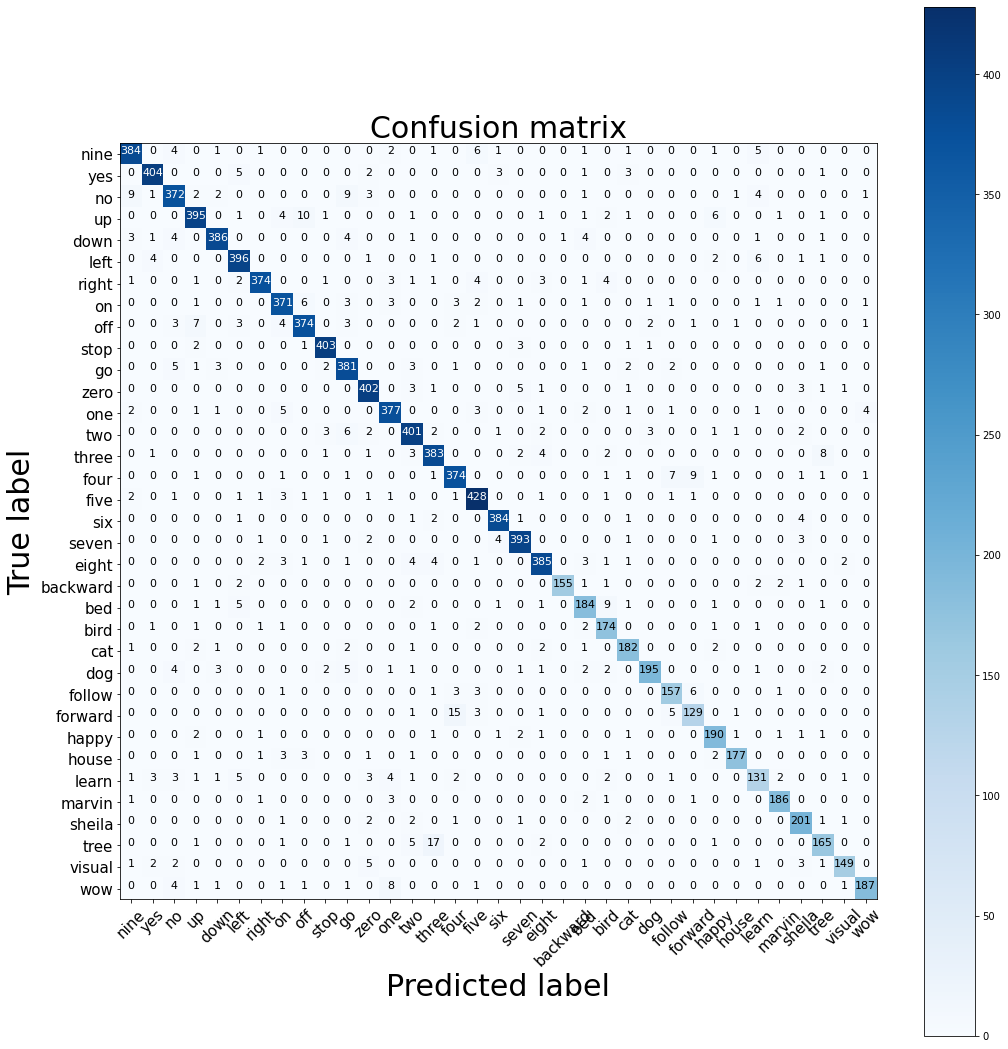

In [ ]:
audioUtils.plot_confusion_matrix(cm, classes, normalize=False)